###**Detecting Insurance Claim Fraud with Machine Learning**

This project aims to detect fraudulent insurance claims using the ‘insurance_claims.csv’ dataset. It involves data preprocessing, feature selection, and applying supervised classification algorithms to predict fraud likelihood, improving fraud detection efficiency for insurance providers.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report # Import confusion_matrix and classification_report
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
#Load the Dataset File
insurance_df = pd.read_csv('insurance_claims.csv')
insurance_df.head()

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1                 228   42         342868       2006-06-27           IN   
2                 134   29         687698       2000-09-06           OH   
3                 256   41         227811       1990-05-25           IL   
4                 228   44         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... police_report_available total_claim_amount injury_claim  \
0       466132  ...                     YES              71610         6510   
1       468176  ...                       ?               5070          780   
2       430632  ...                      NO              34650         7700   
3       608117  ...                      NO              63400         6340   
4       610706  ...                      NO               6500         1300   

  property_claim vehicle_claim  auto_make  auto_model auto_year  \
0          13020         52080       Saab         92x      2004   
1            780          3510   Mercedes        E400      2007   
2           3850         23100      Dodge         RAM      2007   
3           6340         50720  Chevrolet       Tahoe      2014   
4            650          4550     Accura         RSX      2009   

  fraud_reported _c39  
0              Y  NaN  
1              Y  NaN  
2              N  NaN  
3              Y  NaN  
4              N  NaN  

[5 rows x 40 columns]

####**Data Preprocessing**

In [ ]:
# View features, their data types and count of null values
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

**Data Information Summary:**


The dataset consists of 1,000 customer records with 38 features and one target variable. The features encompass customer details, policy information, incident specifics, and a fraud indicator.

Upon inspection, the ‘authorities_contacted’ column contains 91 missing values, while the ’_c39’ column appears to have no values and can be safely dropped.

The other columns did not have any errors or missing values.

In [ ]:
# Drop c_39 column
insurance_df.drop(['_c39'], axis=1, inplace=True)

**Handling Null values in 'Authorities Contacted':**


Upon closer inspection, the ‘Authorities Contacted’ column does not have actual null values; instead, the value “None” was misinterpreted as NaN. To correct this, NaN values were manually replaced with “None” to retain accurate data representation.

In [ ]:
#Replace NaN with "None" in authorities contacted column
insurance_df.fillna({'authorities_contacted':'None'}, inplace=True)
null_count = insurance_df['authorities_contacted'].isna().sum()
print(f"Number of null values in 'Authorities Contacted': {null_count}")

Number of null values in 'Authorities Contacted': 0


In [ ]:
# Summary of numerical columns in data
insurance_df.describe()

months_as_customer          age  policy_number  policy_deductable  \
count         1000.000000  1000.000000    1000.000000        1000.000000   
mean           203.954000    38.948000  546238.648000        1136.000000   
std            115.113174     9.140287  257063.005276         611.864673   
min              0.000000    19.000000  100804.000000         500.000000   
25%            115.750000    32.000000  335980.250000         500.000000   
50%            199.500000    38.000000  533135.000000        1000.000000   
75%            276.250000    44.000000  759099.750000        2000.000000   
max            479.000000    64.000000  999435.000000        2000.000000   

       policy_annual_premium  umbrella_limit    insured_zip  capital-gains  \
count            1000.000000    1.000000e+03    1000.000000    1000.000000   
mean             1256.406150    1.101000e+06  501214.488000   25126.100000   
std               244.167395    2.297407e+06   71701.610941   27872.187708   
min               433.330000   -1.000000e+06  430104.000000       0.000000   
25%              1089.607500    0.000000e+00  448404.500000       0.000000   
50%              1257.200000    0.000000e+00  466445.500000       0.000000   
75%              1415.695000    0.000000e+00  603251.000000   51025.000000   
max              2047.590000    1.000000e+07  620962.000000  100500.000000   

        capital-loss  incident_hour_of_the_day  number_of_vehicles_involved  \
count    1000.000000               1000.000000                   1000.00000   
mean   -26793.700000                 11.644000                      1.83900   
std     28104.096686                  6.951373                      1.01888   
min   -111100.000000                  0.000000                      1.00000   
25%    -51500.000000                  6.000000                      1.00000   
50%    -23250.000000                 12.000000                      1.00000   
75%         0.000000                 17.000000                      3.00000   
max         0.000000                 23.000000                      4.00000   

       bodily_injuries    witnesses  total_claim_amount  injury_claim  \
count      1000.000000  1000.000000          1000.00000   1000.000000   
mean          0.992000     1.487000         52761.94000   7433.420000   
std           0.820127     1.111335         26401.53319   4880.951853   
min           0.000000     0.000000           100.00000      0.000000   
25%           0.000000     1.000000         41812.50000   4295.000000   
50%           1.000000     1.000000         58055.00000   6775.000000   
75%           2.000000     2.000000         70592.50000  11305.000000   
max           2.000000     3.000000        114920.00000  21450.000000   

       property_claim  vehicle_claim    auto_year  
count     1000.000000    1000.000000  1000.000000  
mean      7399.570000   37928.950000  2005.103000  
std       4824.726179   18886.252893     6.015861  
min          0.000000      70.000000  1995.000000  
25%       4445.000000   30292.500000  2000.000000  
50%       6750.000000   42100.000000  2005.000000  
75%      10885.000000   50822.500000  2010.000000  
max      23670.000000   79560.000000  2015.000000

####**Exploratory Data Analysis**

**Feature Distribution**

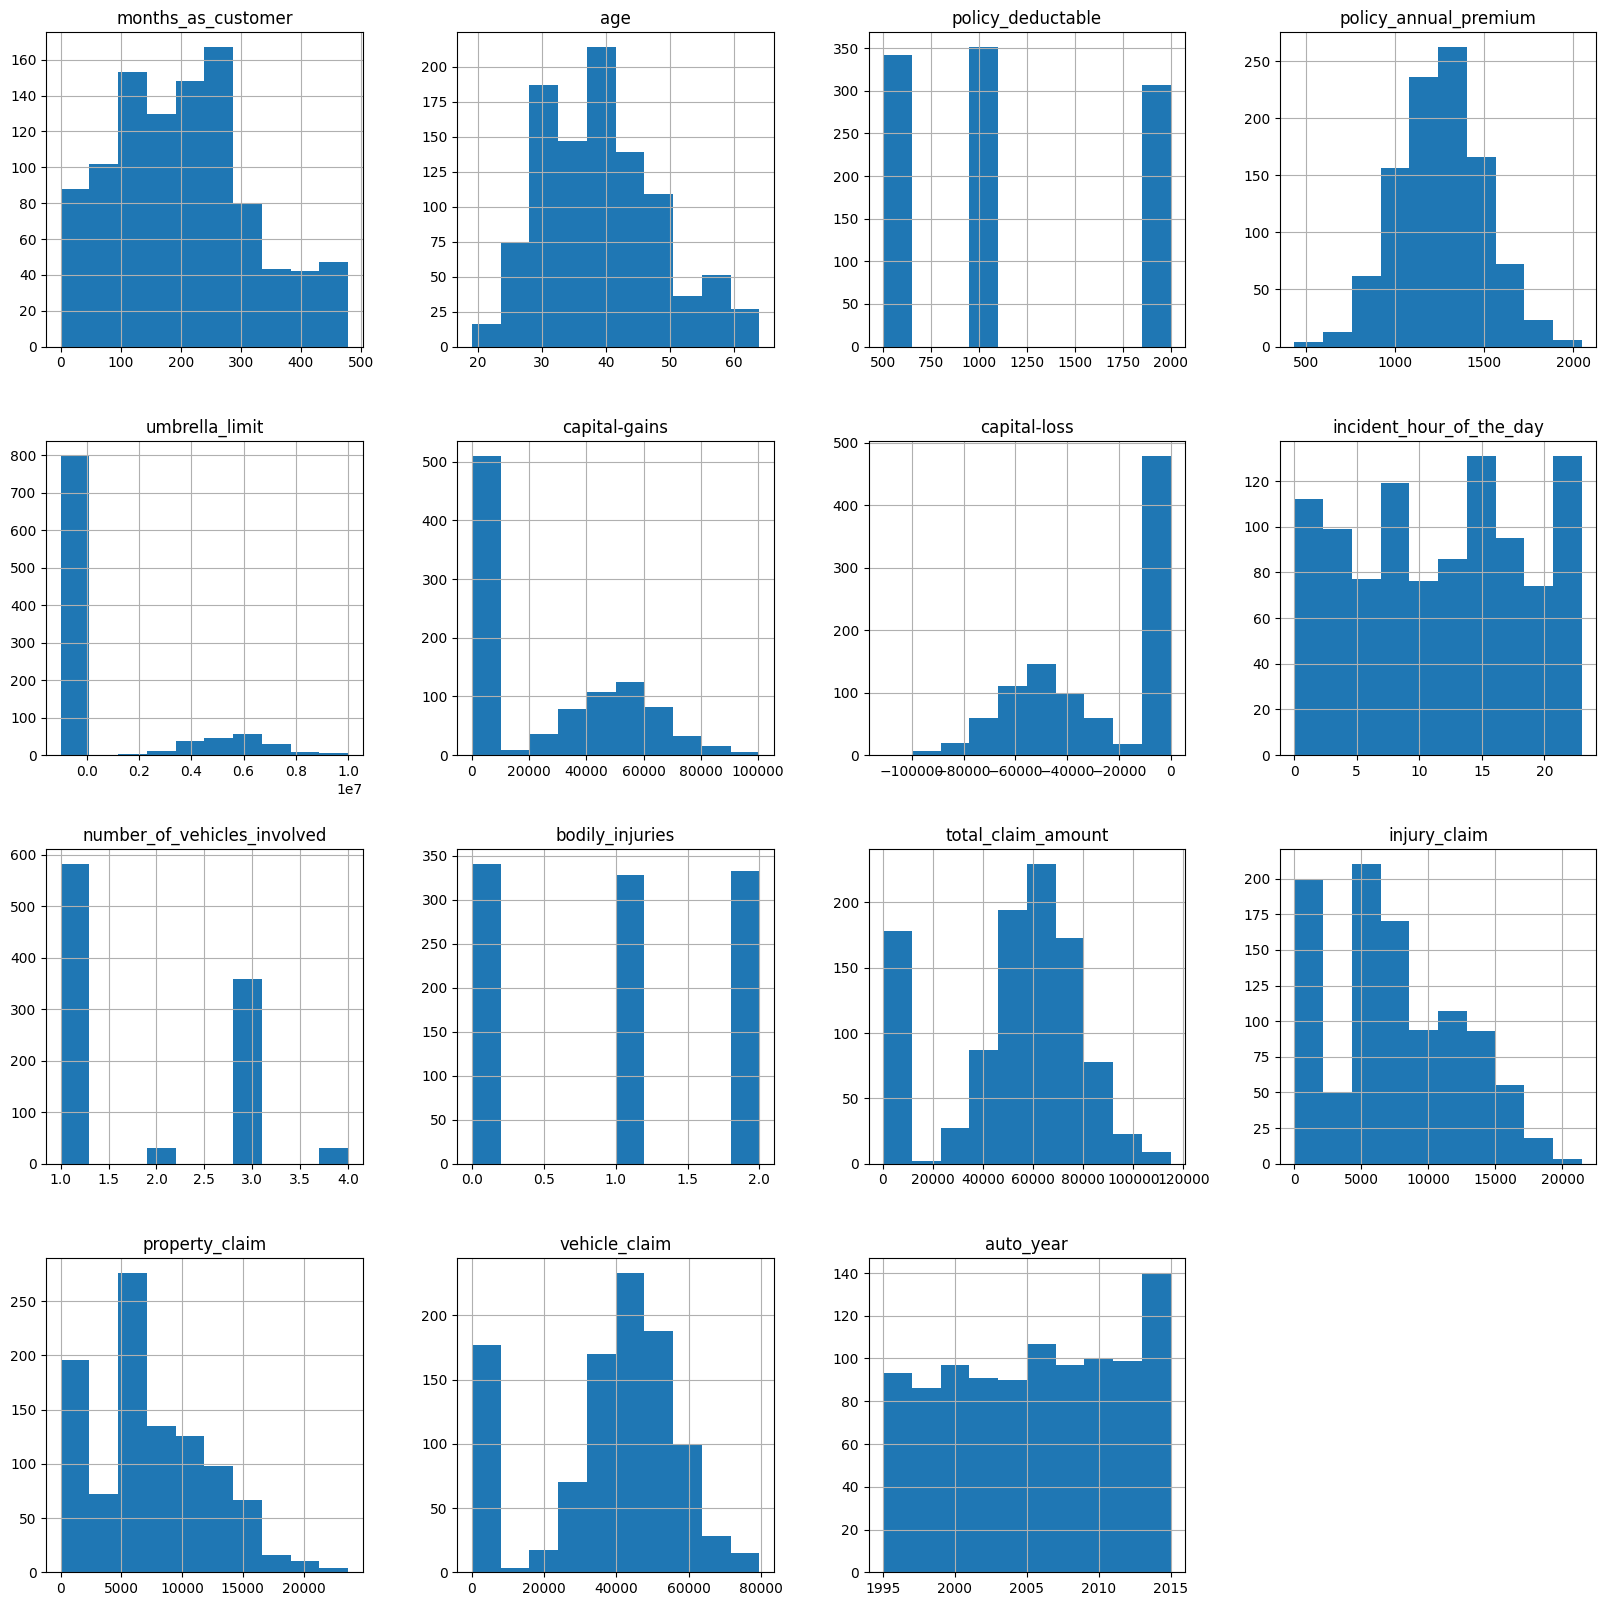

In [ ]:
# Drop numerical columns that do not provide meaningful business insights when plotted as distributions
df_filtered = insurance_df.drop(columns=['policy_number', 'insured_zip', 'witnesses'])

# Plot histogram for all numerical columns
df_filtered.hist(figsize=(20,20))
plt.show()

General Insights from Histograms of Insurance Claims Data:

1. Claim Amount:


Right-skewed Distribution: The histogram of claim amounts is right-skewed, indicating that most claims are for smaller amounts, with a few larger claims driving the tail of the distribution.



2. Age:

Roughly Normal or Bimodal Distribution: The histogram of insured age is observed to be a bimodal distribution which indicates distinct customer segments (e.g., younger and older drivers).

Impact on Risk: Age is an important factor in assessing risk, as younger and older drivers may have higher accident rates compared to middle-aged drivers.


3. Policy Deductible & Policy Annual Premium:

Policy deductible is $500, $1,000 or $2,000.

The policy annual premium appears to be normally distributed with a mean of about $1,256.


4. Umbrella Limit, Capital Gains & Capital Loss:

A significant proportion of customers have an umbrella limit, capital gain, or capital loss of $0, indicating that these financial protections or transactions are either uncommon or not utilized by most policyholders. This trend could suggest a lower prevalence of high-net-worth individuals in the dataset or a general preference for minimal risk coverage.

5. Claim Distribution:

Total Claim is the sum of vehicle claim, injury claim, and property claim. The distribution of claims is right-skewed, with a large number of customers having no claims, while the number of customers decreases as claim amounts increase. Notably, there is a spike in vehicle claims between $4000

and

$5000, which also influences the overall claim distribution since vehicle claims make up the largest portion of total claims.

**Correlation Heatmap**

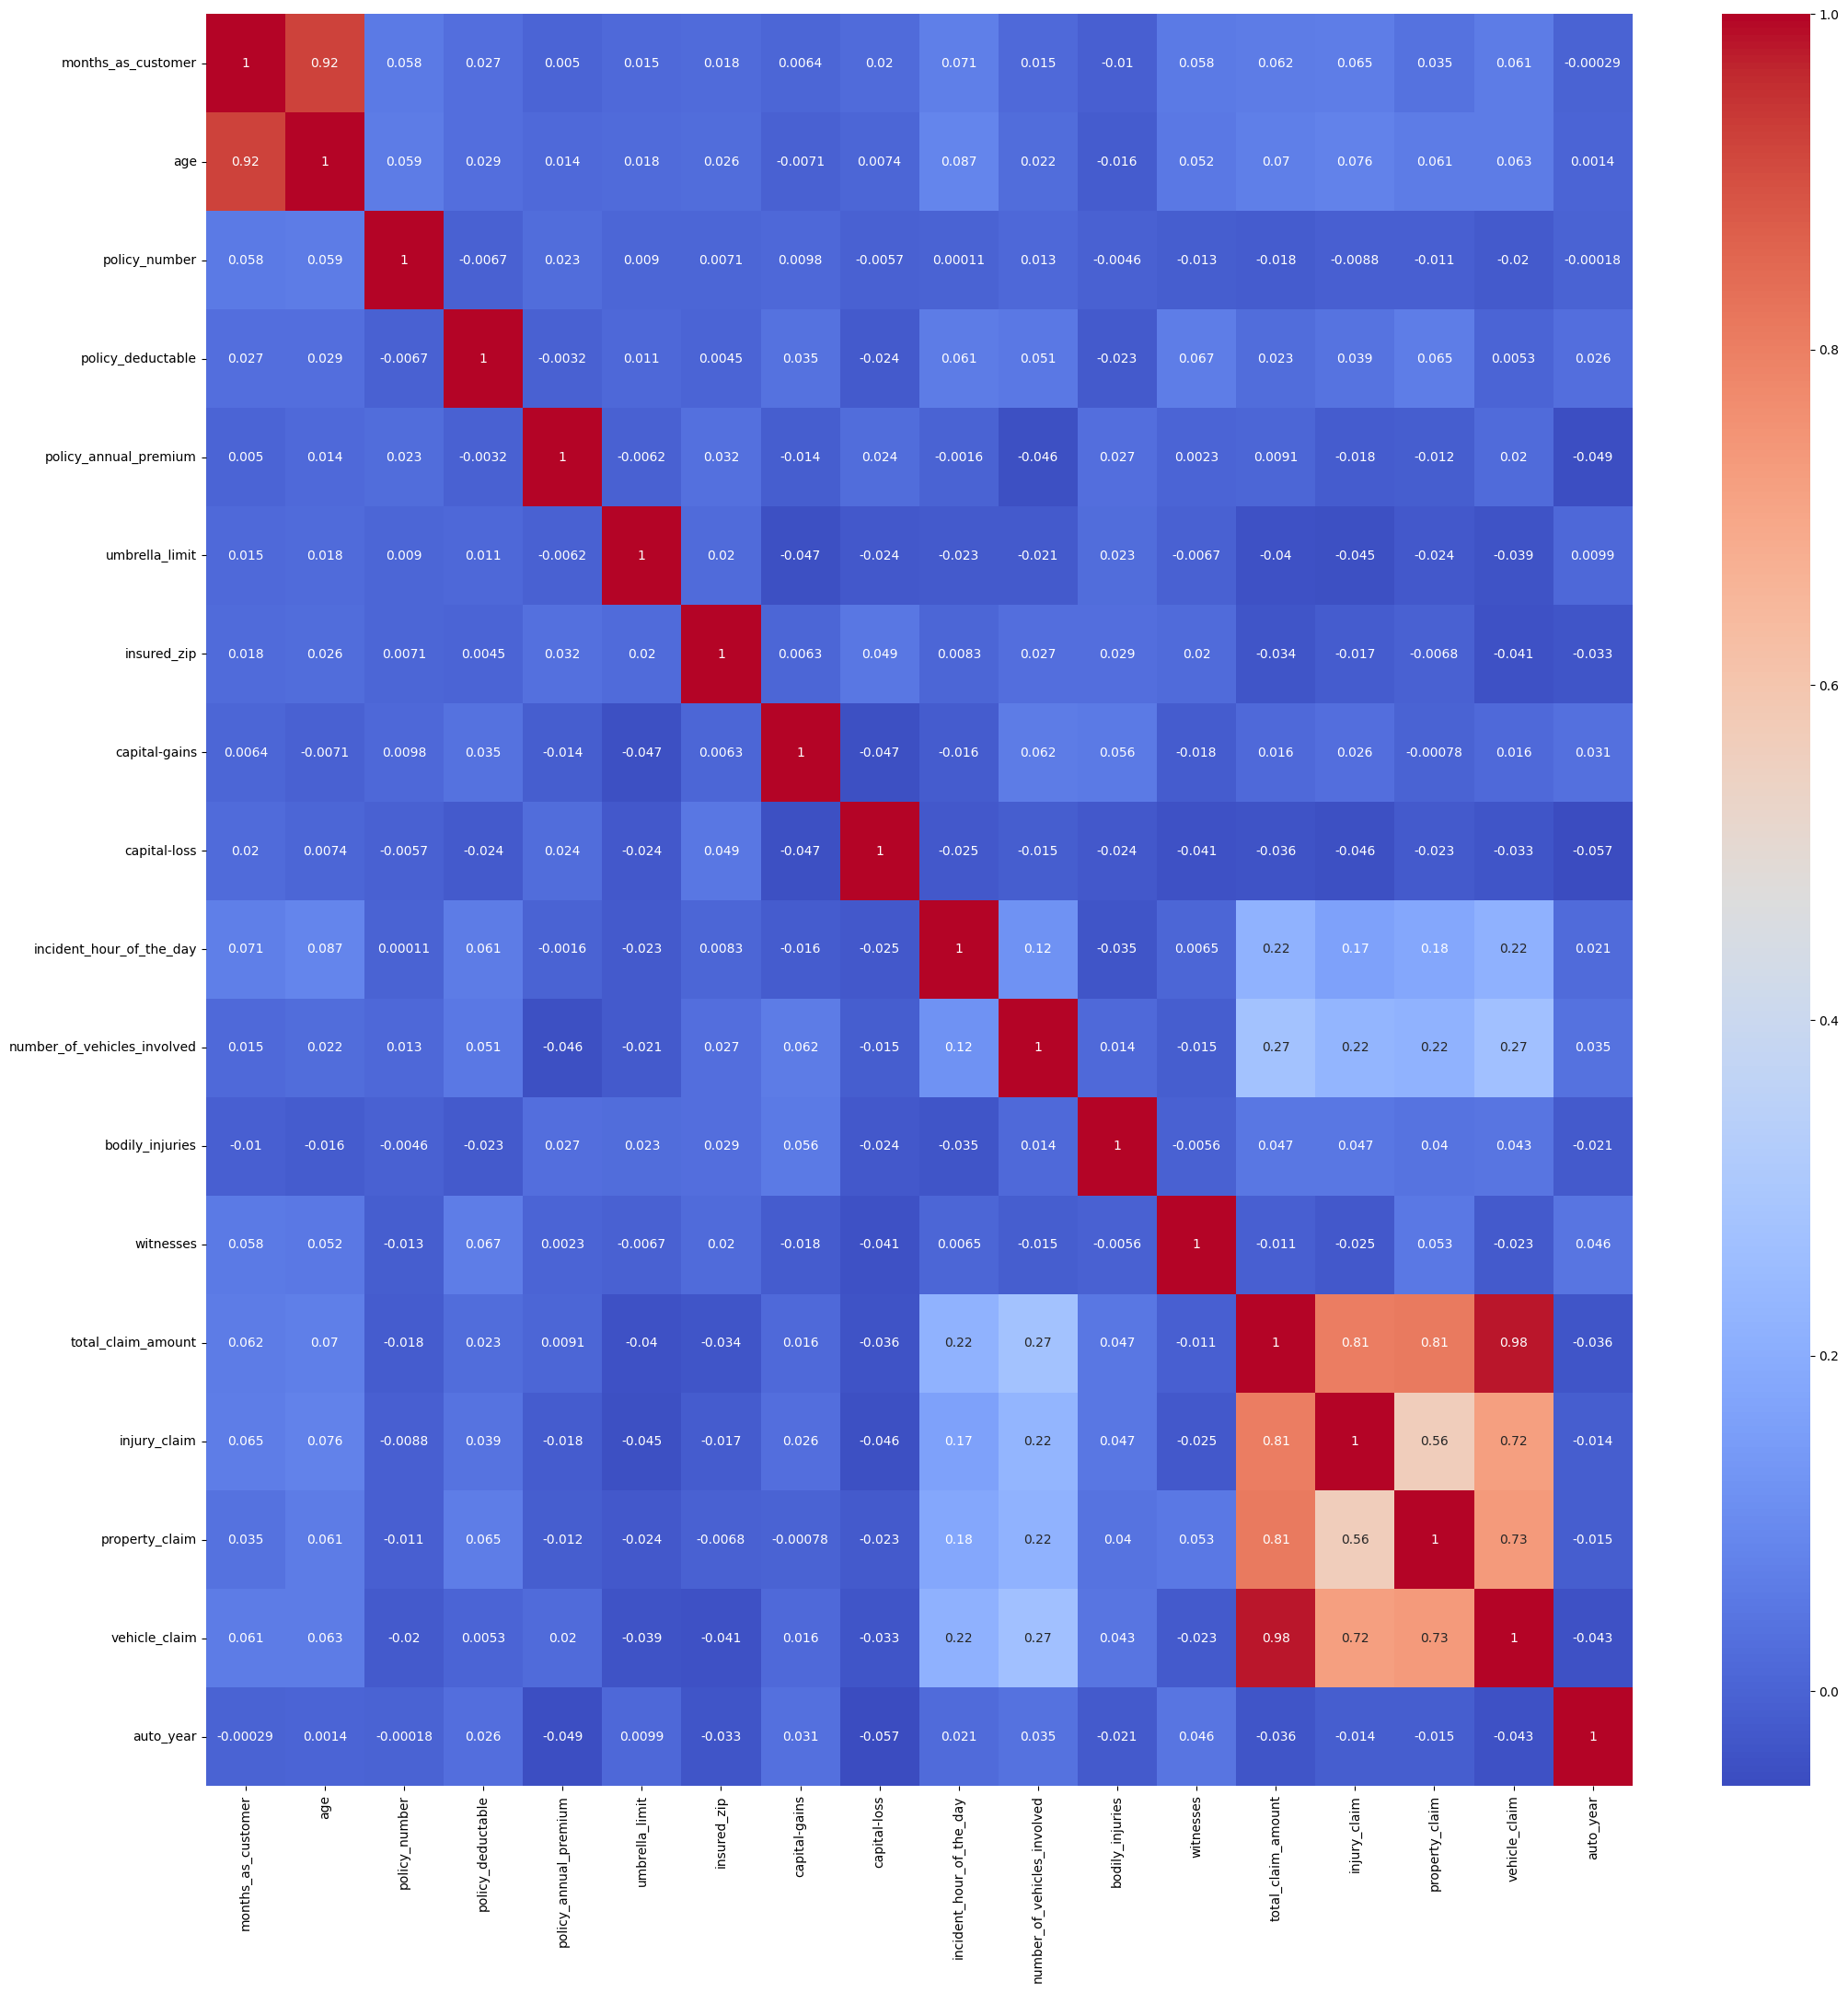

In [ ]:
#select numerical columns
numerical_columns = insurance_df.select_dtypes(include=['int64','float64']).columns
#correlation matrix
correlation_matrix = insurance_df[numerical_columns].corr()
plt.figure(figsize=(25,25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

The correlation matrix shows a high correlation between total_claim_amount and injury_claim, property_claim, and vehicle_claim, as total_claim_amount is simply their sum. Given this redundancy, the total_claim_amount column can be dropped to avoid multicollinearity.

**Scatterplot**

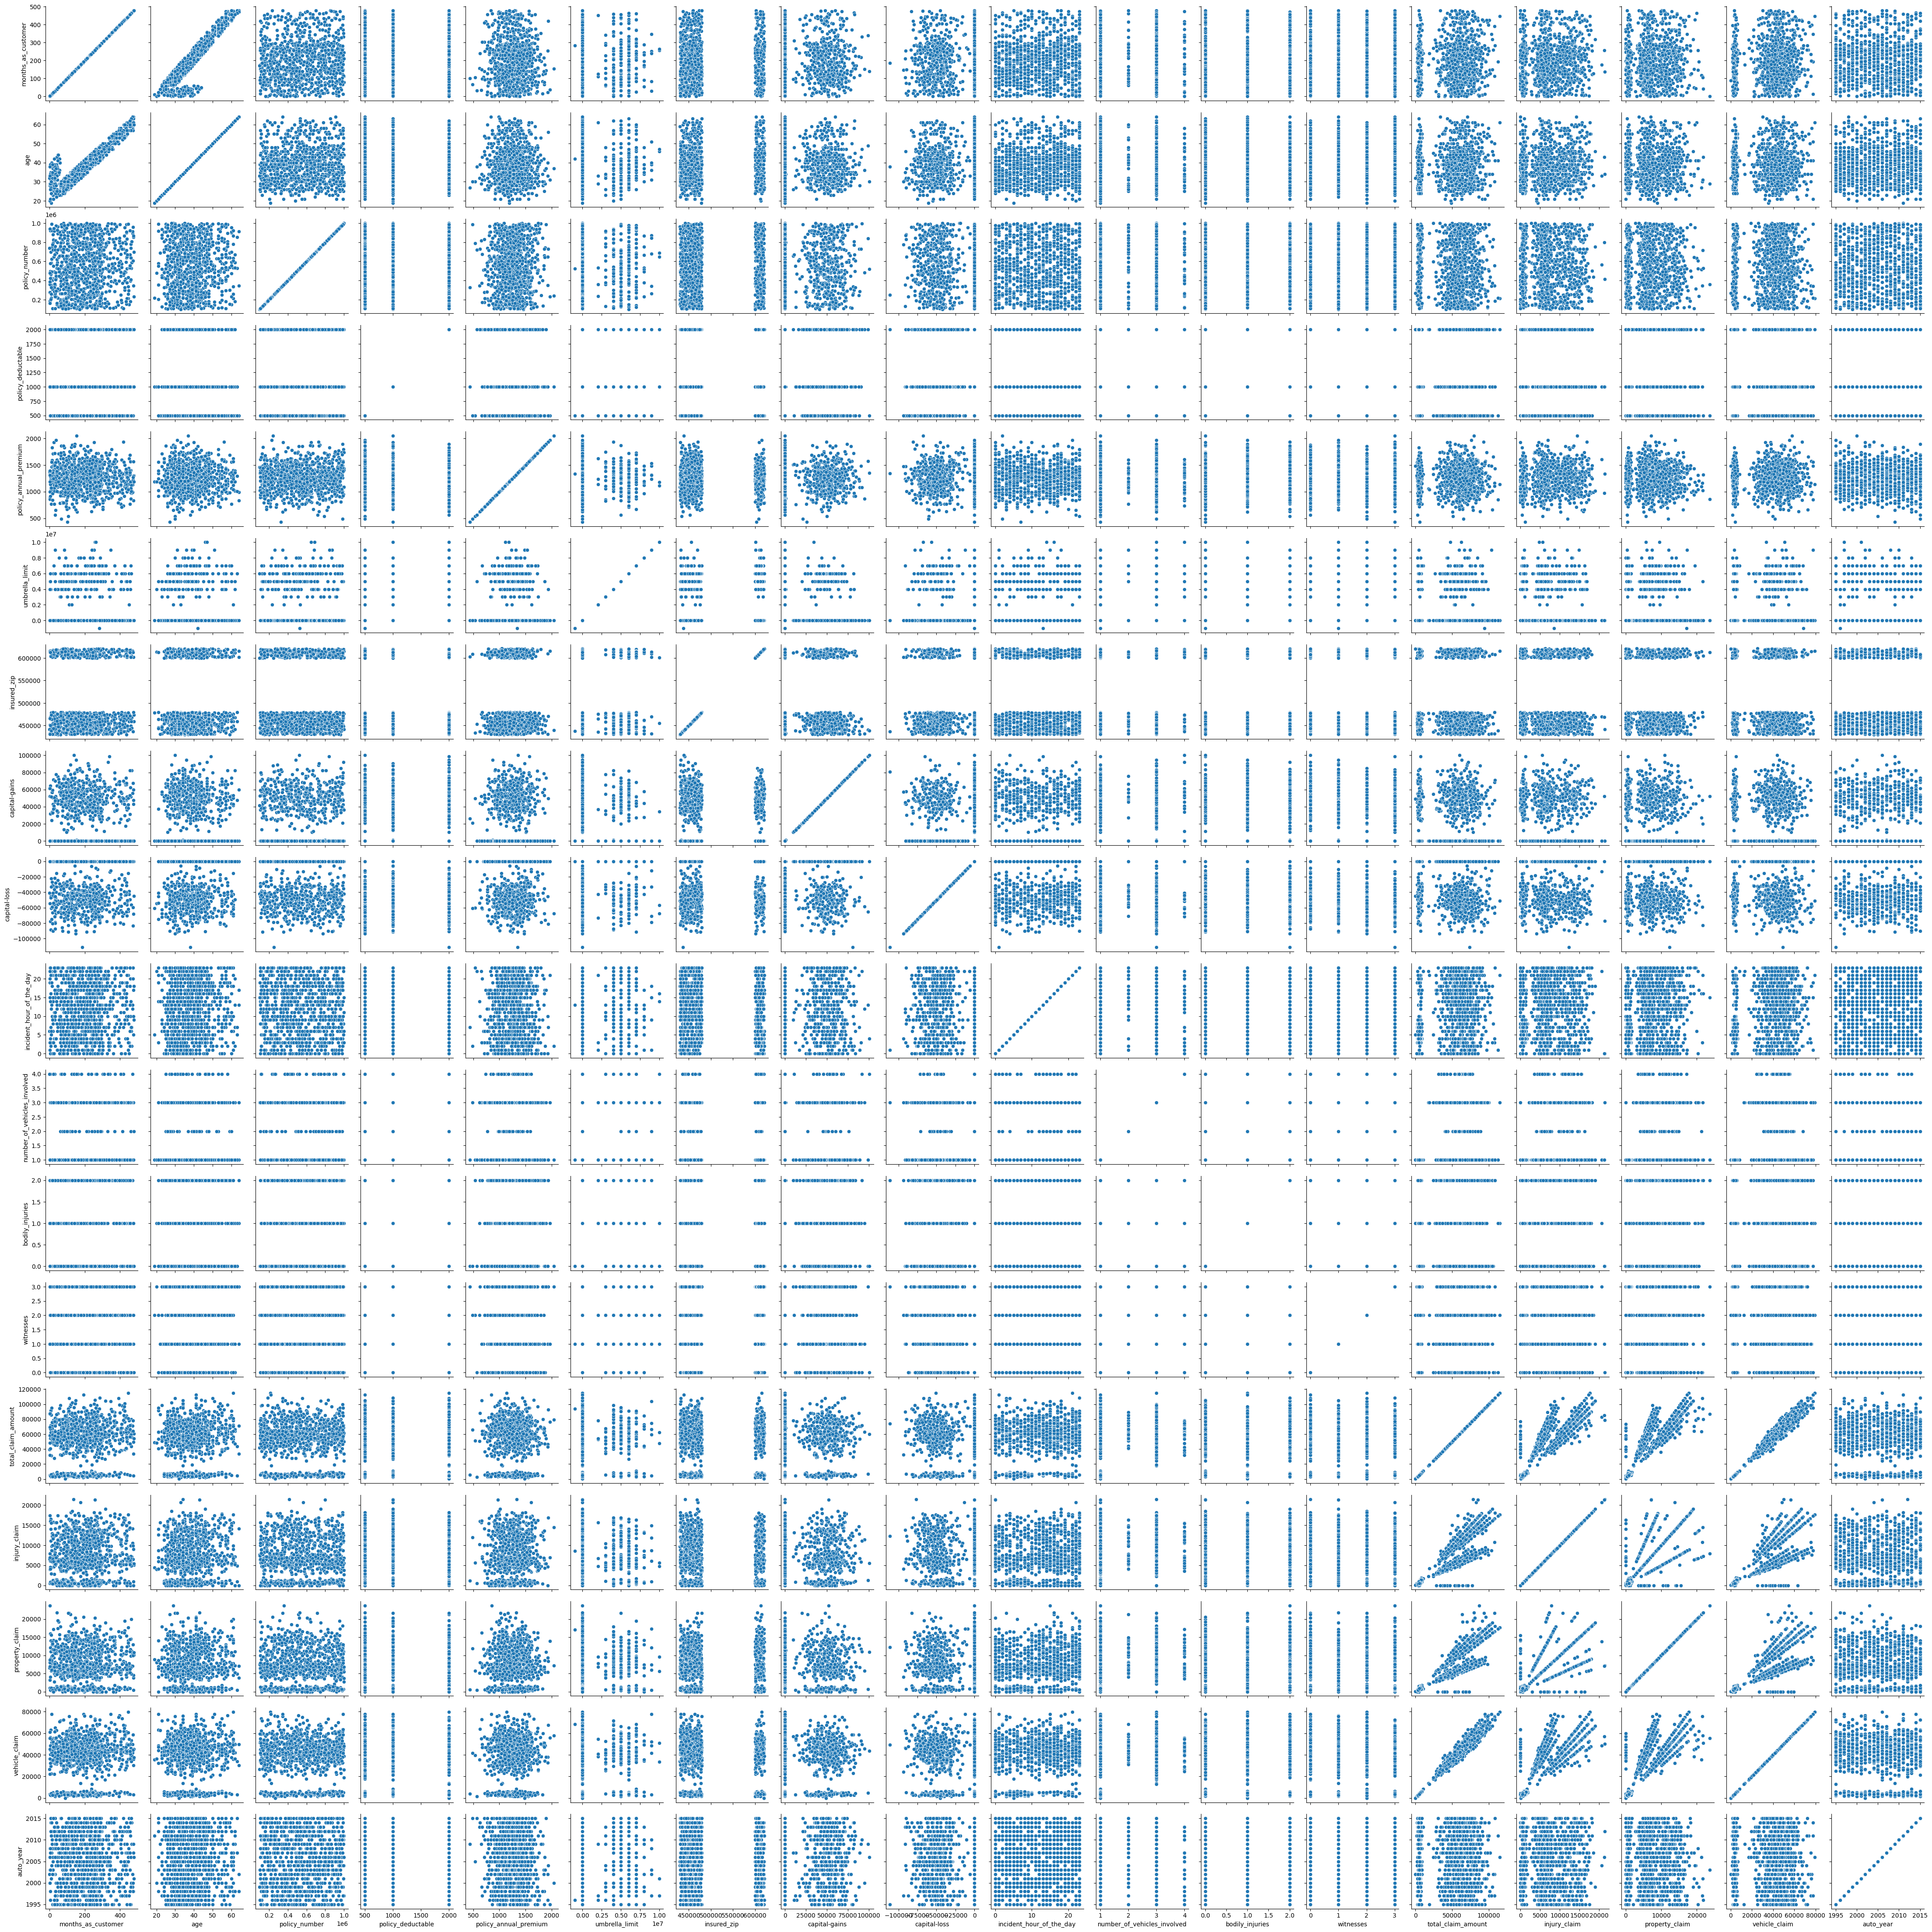

<Figure size 4000x4000 with 0 Axes>

In [ ]:
sns.pairplot(insurance_df, kind="scatter", diag_kind=None)
plt.figure(figsize=(40,40))
plt.show()

**Boxplot Analysis for Outlier Detection**

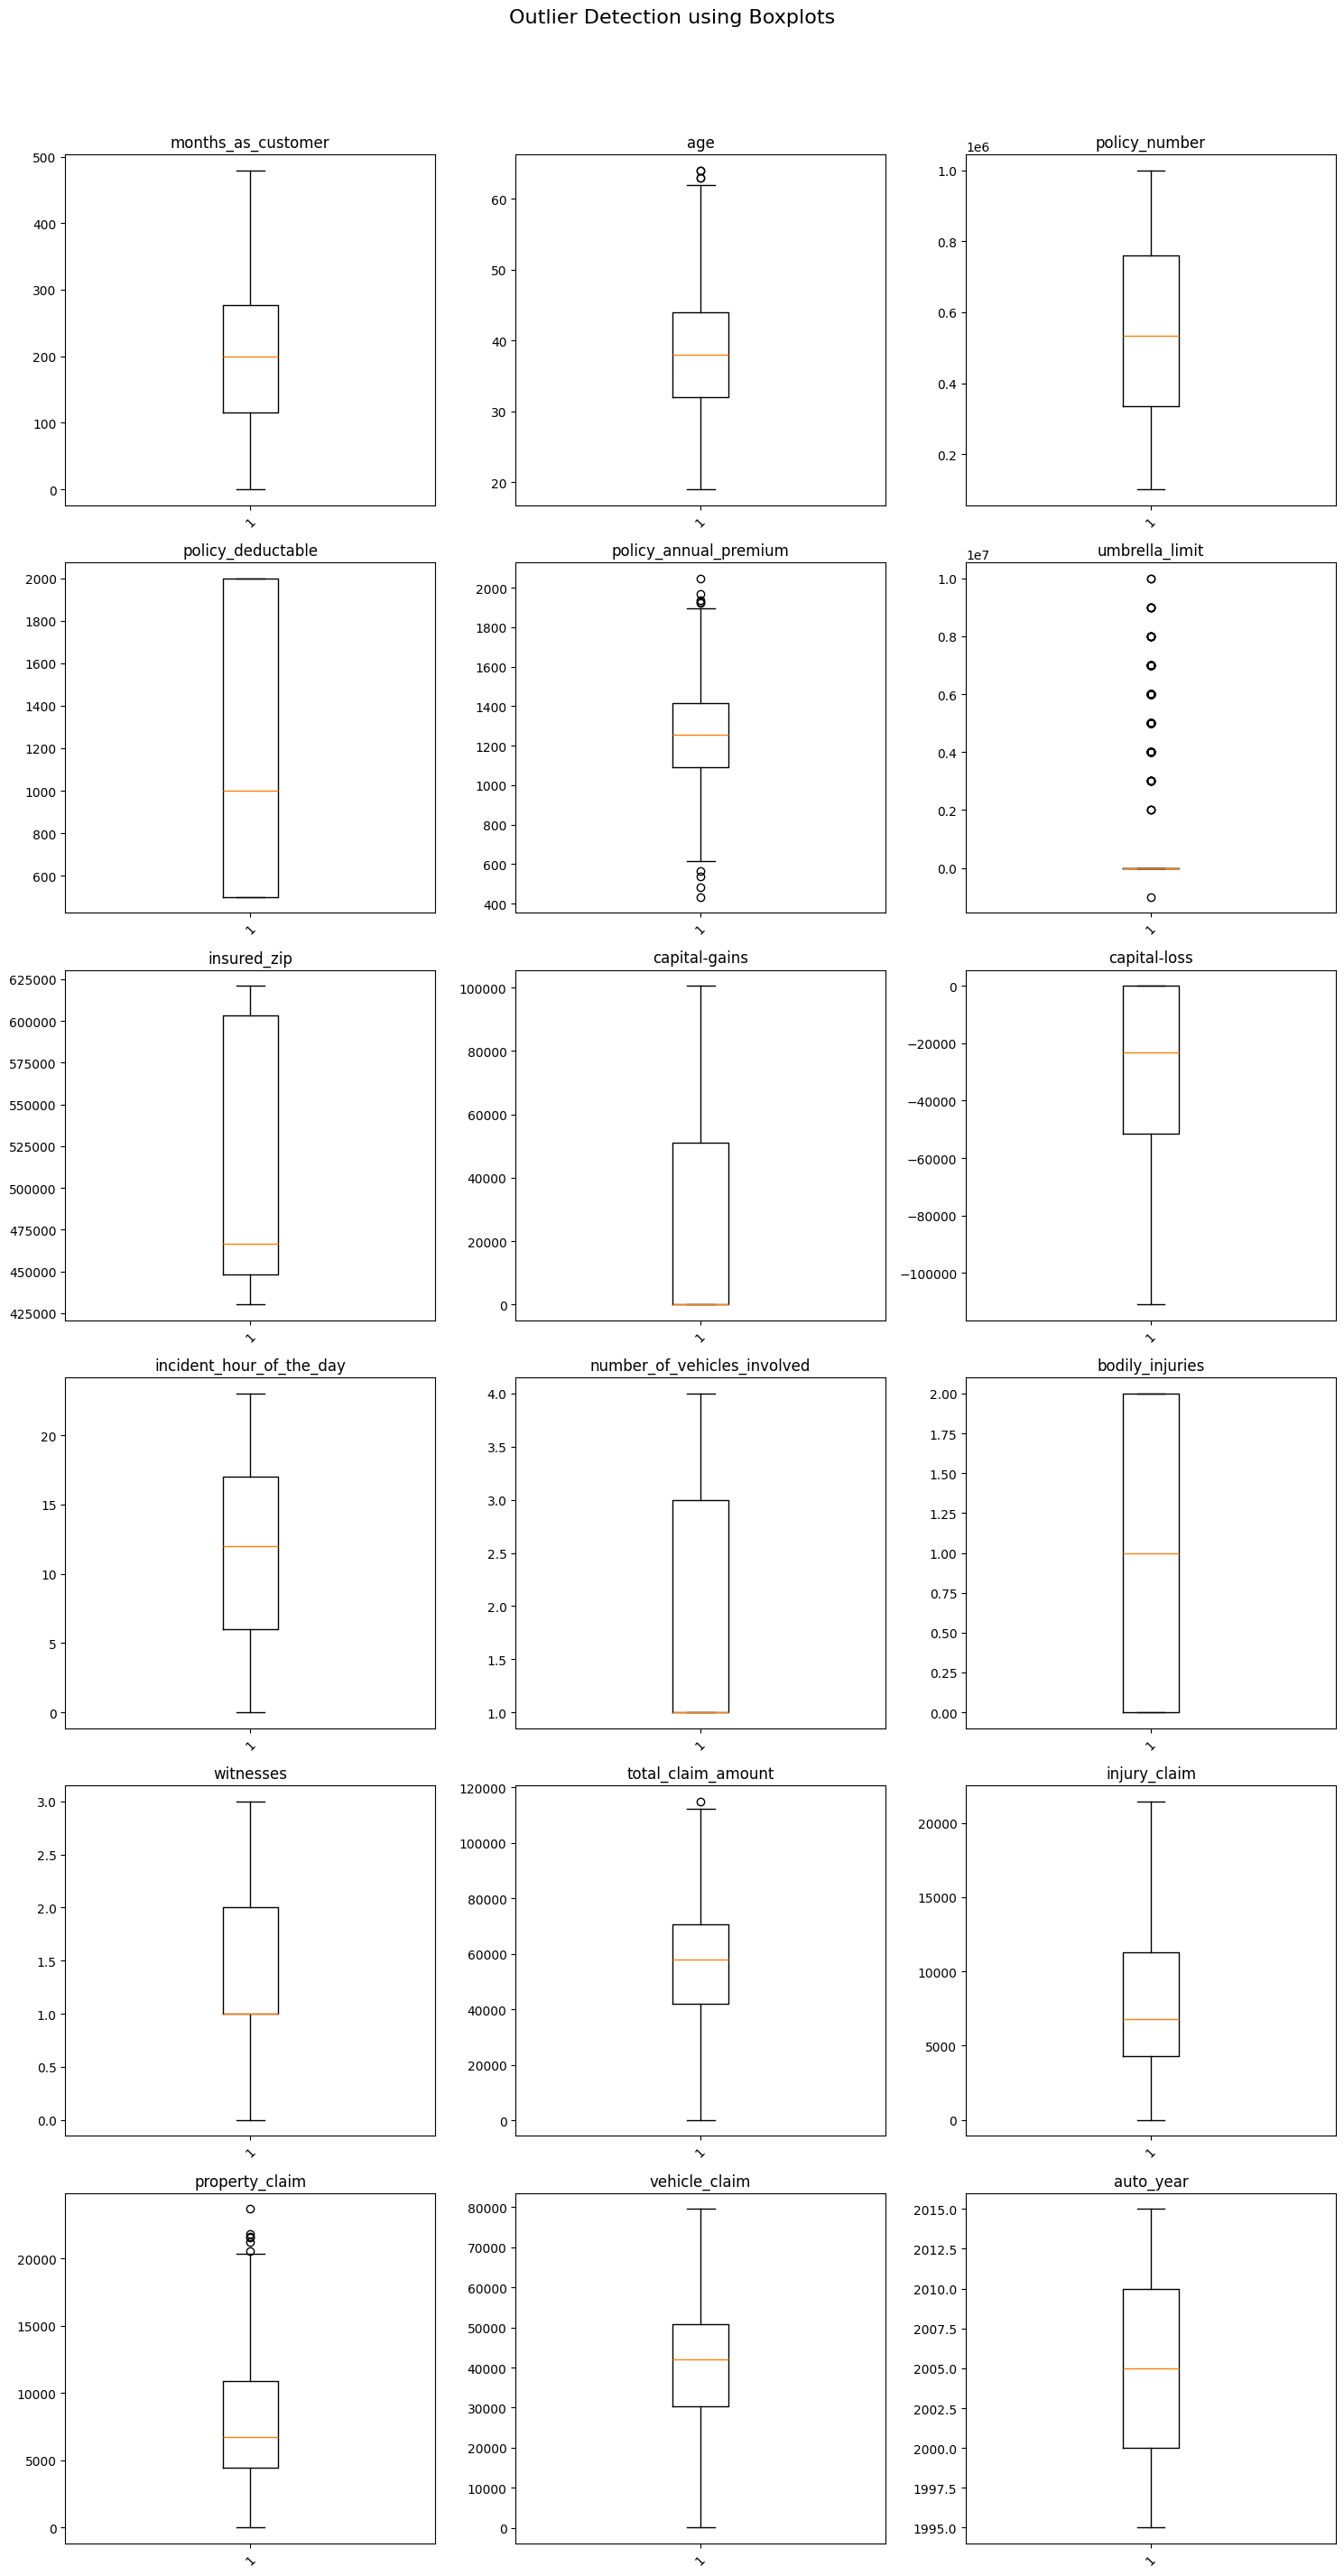

In [ ]:
# Outlier Detection using Boxplots
# Calculate the number of rows needed for the subplots
num_rows = (len(numerical_columns) + 2) // 3

# Adjust figure size to accommodate all subplots and prevent overlap
plt.figure(figsize=(15, 5 * num_rows))

# Create boxplots for each column in subplots
for i, col in enumerate(numerical_columns):
    plt.subplot(num_rows, 3, i + 1)
    # Using plt.boxplot to create the boxplot for the column
    plt.boxplot(insurance_df[col])
    plt.title(col)
    plt.xticks(rotation=45)  # Rotate x-axis labels

plt.suptitle("Outlier Detection using Boxplots", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The majority of data points fall within the interquartile range (IQR), suggesting that outliers have minimal impact on the dataset.

**Summary of Categorical Variables**

In [ ]:
#Extract categorical variable columns
categorical_columns = insurance_df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    print(f"Feature: {col}")
    print(insurance_df[col].value_counts())
    print("-" * 20)

Feature: policy_bind_date
policy_bind_date
1992-08-05    3
2006-01-01    3
1992-04-28    3
1996-07-07    2
2002-07-16    2
             ..
1999-02-18    1
1997-10-30    1
1999-11-29    1
2013-07-07    1
1991-08-02    1
Name: count, Length: 951, dtype: int64
--------------------
Feature: policy_state
policy_state
OH    352
IL    338
IN    310
Name: count, dtype: int64
--------------------
Feature: policy_csl
policy_csl
250/500     351
100/300     349
500/1000    300
Name: count, dtype: int64
--------------------
Feature: insured_sex
insured_sex
FEMALE    537
MALE      463
Name: count, dtype: int64
--------------------
Feature: insured_education_level
insured_education_level
JD             161
High School    160
Associate      145
MD             144
Masters        143
PhD            125
College        122
Name: count, dtype: int64
--------------------
Feature: insured_occupation
insured_occupation
machine-op-inspct    93
prof-specialty       85
tech-support         78
sales              

**Class Imbalance**

In [ ]:
#Calculate class imbalance
insurance_df['fraud_reported'].value_counts()

fraud_reported
N    753
Y    247
Name: count, dtype: int64

The count of records reported as fraud indicate there is class imbalance. This needs to be addressed during classification through class imbalance handling techniques.

####**Model Building**

**Feature Selection**

In [ ]:
#Remove unnecessary columns to eliminate irrelevant or redundant data, reducing overfitting, and speeding up the computation process.
insurance_df.drop(['age', 'policy_bind_date', 'policy_number','policy_csl','policy_deductable','insured_relationship','incident_hour_of_the_day','umbrella_limit', 'insured_zip','insured_hobbies', 'capital-gains', 'capital-loss', 'incident_city', 'incident_date', 'incident_location', 'witnesses','number_of_vehicles_involved', 'auto_make', 'auto_year'], axis=1, inplace=True)
insurance_df.head()

months_as_customer policy_state  policy_annual_premium insured_sex  \
0                 328           OH                1406.91        MALE   
1                 228           IN                1197.22        MALE   
2                 134           OH                1413.14      FEMALE   
3                 256           IL                1415.74      FEMALE   
4                 228           IL                1583.91        MALE   

  insured_education_level insured_occupation             incident_type  \
0                      MD       craft-repair  Single Vehicle Collision   
1                      MD  machine-op-inspct             Vehicle Theft   
2                     PhD              sales   Multi-vehicle Collision   
3                     PhD       armed-forces  Single Vehicle Collision   
4               Associate              sales             Vehicle Theft   

    collision_type incident_severity authorities_contacted incident_state  \
0   Side Collision      Major Damage                Police             SC   
1                ?      Minor Damage                Police             VA   
2   Rear Collision      Minor Damage                Police             NY   
3  Front Collision      Major Damage                Police             OH   
4                ?      Minor Damage                  None             NY   

  property_damage  bodily_injuries police_report_available  \
0             YES                1                     YES   
1               ?                0                       ?   
2              NO                2                      NO   
3               ?                1                      NO   
4              NO                0                      NO   

   total_claim_amount  injury_claim  property_claim  vehicle_claim auto_model  \
0               71610          6510           13020          52080        92x   
1                5070           780             780           3510       E400   
2               34650          7700            3850          23100        RAM   
3               63400          6340            6340          50720      Tahoe   
4                6500          1300             650           4550        RSX   

  fraud_reported  
0              Y  
1              Y  
2              N  
3              Y  
4              N

**Encoding Categorical Variables**

In [ ]:
# Extract columns with categorical variables from updated data
categorical_columns = insurance_df.select_dtypes(include=['object']).columns

# Perform Label Encoding to covert text to numerical values
label_encoder = LabelEncoder()
for col in categorical_columns:
    insurance_df[col] = label_encoder.fit_transform(insurance_df[col])

insurance_df.head()

months_as_customer  policy_state  policy_annual_premium  insured_sex  \
0                 328             2                1406.91            1   
1                 228             1                1197.22            1   
2                 134             2                1413.14            0   
3                 256             0                1415.74            0   
4                 228             0                1583.91            1   

   insured_education_level  insured_occupation  incident_type  collision_type  \
0                        4                   2              2               3   
1                        4                   6              3               0   
2                        6                  11              0               2   
3                        6                   1              2               1   
4                        0                  11              3               0   

   incident_severity  authorities_contacted  incident_state  property_damage  \
0                  0                      4               4                2   
1                  1                      4               5                0   
2                  1                      4               1                1   
3                  0                      4               2                0   
4                  1                      2               1                1   

   bodily_injuries  police_report_available  total_claim_amount  injury_claim  \
0                1                        2               71610          6510   
1                0                        0                5070           780   
2                2                        1               34650          7700   
3                1                        1               63400          6340   
4                0                        1                6500          1300   

   property_claim  vehicle_claim  auto_model  fraud_reported  
0           13020          52080           1               1  
1             780           3510          12               1  
2            3850          23100          30               0  
3            6340          50720          34               1  
4             650           4550          31               0

**Split model into train and test set**

In [ ]:
#split model into train and test
X = insurance_df.drop('fraud_reported', axis=1)
y = insurance_df['fraud_reported']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model 1: Logistic Regression**

In [ ]:
# Build a pipeline with SMOTE and Logistic Regression

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score)
}

pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)

# Display results
print("Cross-Validation Results:")
for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

# Train the model
pipeline.fit(x_train, y_train)

# Make predictions
y_pred = pipeline.predict(x_test)

Cross-Validation Results:
accuracy: 0.7437


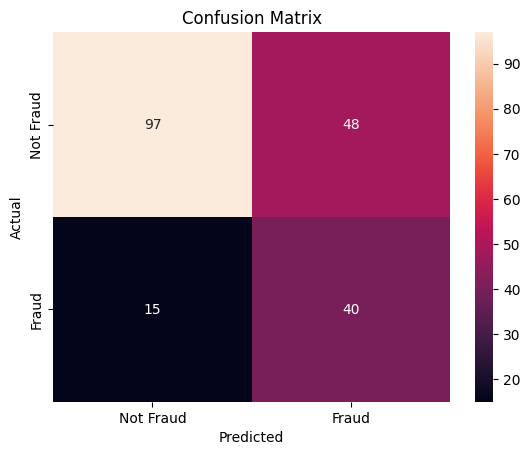

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.75       145
           1       0.45      0.73      0.56        55

    accuracy                           0.69       200
   macro avg       0.66      0.70      0.66       200
weighted avg       0.75      0.69      0.70       200



**Model 2: Random Forest Algorithm**

In [ ]:
#performing second model using RandomForestClassifier
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Train the model
pipeline.fit(x_train, y_train)

# Make predictions
y_pred = pipeline.predict(x_test)

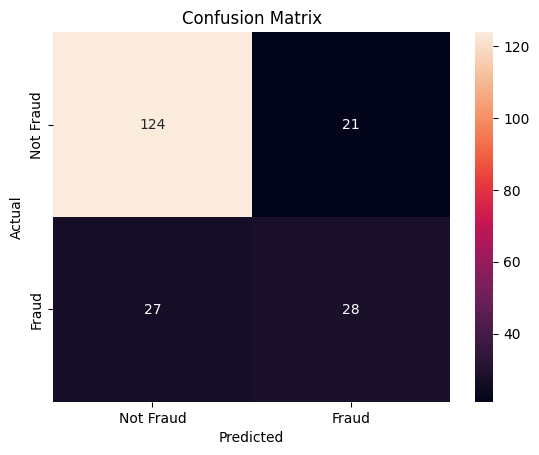

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       145
           1       0.57      0.51      0.54        55

    accuracy                           0.76       200
   macro avg       0.70      0.68      0.69       200
weighted avg       0.75      0.76      0.76       200



**Model 3: XGBoost Classifier**

In [ ]:
# Count class distribution in training data
class_0_count = sum(y_train == 0)
class_1_count = sum(y_train == 1)

# Calculate the weight
scale_pos_weight = class_0_count / class_1_count
model = XGBClassifier(scale_pos_weight=class_0_count / class_1_count)

#initialize and train the model
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
xgb_model.fit(x_train, y_train)


y_probs = xgb_model.predict_proba(x_test)[:, 1]
threshold = 0.3
y_pred = (y_probs >= threshold).astype(int)

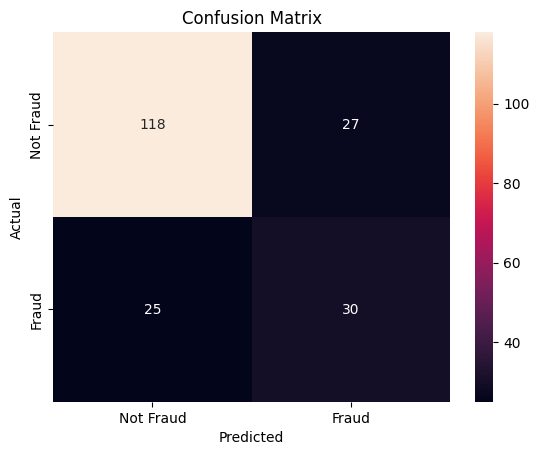

In [ ]:
#Confustion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       145
           1       0.53      0.55      0.54        55

    accuracy                           0.74       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.74      0.74      0.74       200



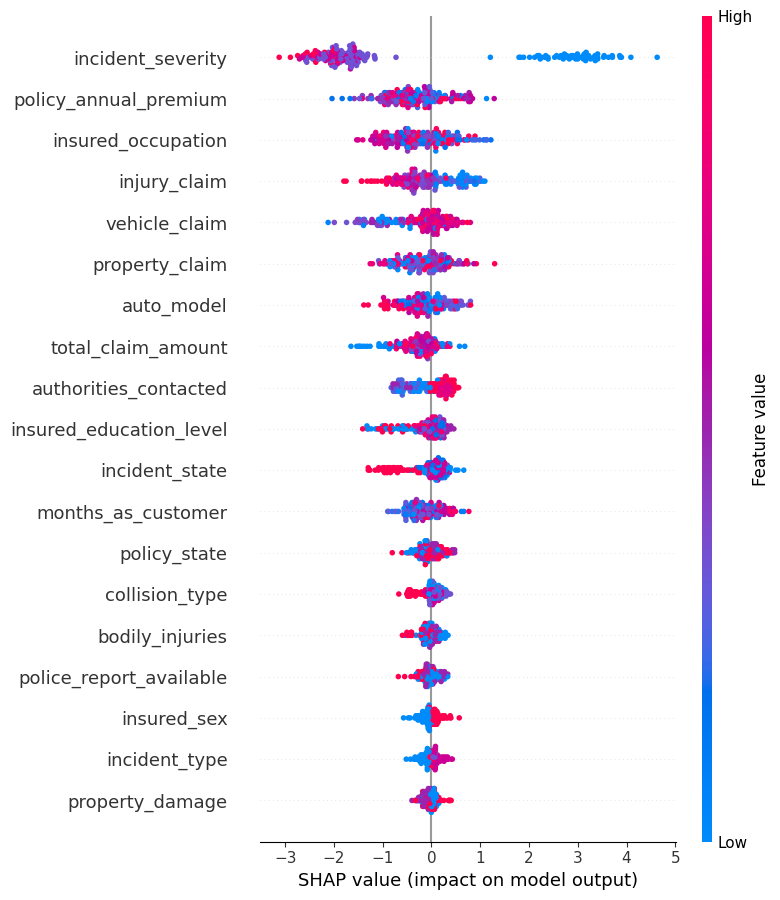

In [ ]:
#perform SHAP analysis to determine variable importance
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(x_test)

#plot
shap.summary_plot(shap_values, x_test)

**Model 4: Ensemble Model**

In [ ]:
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
], voting='soft')

ensemble.fit(x_train, y_train)

y_probs = ensemble.predict_proba(x_test)[:, 1]
y_pred = (y_probs >= 0.4).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


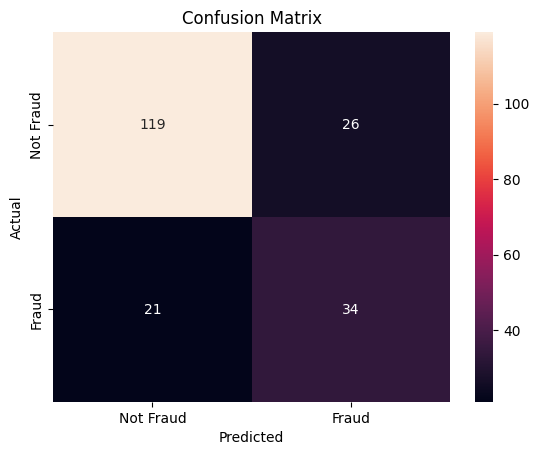

In [ ]:
#Confustion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       145
           1       0.57      0.62      0.59        55

    accuracy                           0.77       200
   macro avg       0.71      0.72      0.71       200
weighted avg       0.77      0.77      0.77       200



**Model 5: Feedforward Neural Network**

In [ ]:
# Preprocess: scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Split training into train and validation sets
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)

# Define the model
class FNNClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FNNClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

model = FNNClassifier(X_train_scaled.shape[1])

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with early stopping
epochs = 100
patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_outputs = model(val_x).squeeze()
            val_loss += criterion(val_outputs, val_y).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping condition
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load the best model
model.load_state_dict(best_model_state)

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).squeeze().numpy()
    y_pred = (y_pred_prob > 0.35).astype(int)

Epoch [1/100] Train Loss: 0.6468 | Val Loss: 0.6218
Epoch [2/100] Train Loss: 0.6086 | Val Loss: 0.5759
Epoch [3/100] Train Loss: 0.5719 | Val Loss: 0.5372
Epoch [4/100] Train Loss: 0.5489 | Val Loss: 0.5122
Epoch [5/100] Train Loss: 0.5367 | Val Loss: 0.4999
Epoch [6/100] Train Loss: 0.5332 | Val Loss: 0.4889
Epoch [7/100] Train Loss: 0.5232 | Val Loss: 0.4805
Epoch [8/100] Train Loss: 0.5112 | Val Loss: 0.4716
Epoch [9/100] Train Loss: 0.5079 | Val Loss: 0.4639
Epoch [10/100] Train Loss: 0.5003 | Val Loss: 0.4570
Epoch [11/100] Train Loss: 0.5020 | Val Loss: 0.4513
Epoch [12/100] Train Loss: 0.4977 | Val Loss: 0.4446
Epoch [13/100] Train Loss: 0.4821 | Val Loss: 0.4392
Epoch [14/100] Train Loss: 0.4768 | Val Loss: 0.4340
Epoch [15/100] Train Loss: 0.4743 | Val Loss: 0.4294
Epoch [16/100] Train Loss: 0.4757 | Val Loss: 0.4245
Epoch [17/100] Train Loss: 0.4621 | Val Loss: 0.4206
Epoch [18/100] Train Loss: 0.4511 | Val Loss: 0.4178
Epoch [19/100] Train Loss: 0.4524 | Val Loss: 0.4136
Ep

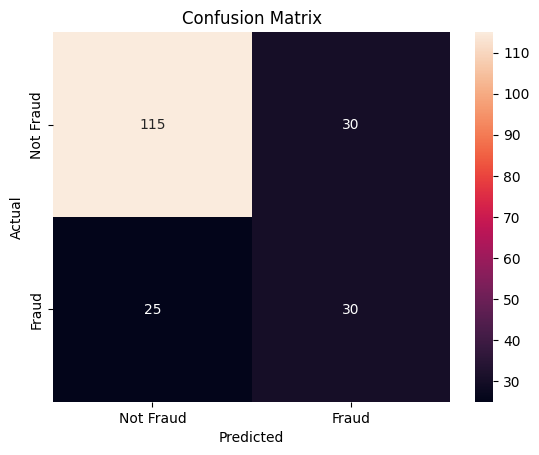

In [ ]:
#Confustion Matrix
cm = confusion_matrix(y_test.values, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Classification Report
print("\nClassification Report:")
print(classification_report(y_test.values, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       145
           1       0.50      0.55      0.52        55

    accuracy                           0.72       200
   macro avg       0.66      0.67      0.66       200
weighted avg       0.73      0.72      0.73       200



**Model Comparison**

In [ ]:
import pandas as pd

# Define the model comparison metrics
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Ensemble Model', 'Neural Network']
metrics = {
    'Accuracy': [0.73, 0.77, 0.74, 0.77, 0.75],
    'Precision': [0.69, 0.71, 0.68, 0.71, 0.69],
    'Recall': [0.73, 0.69, 0.68, 0.72, 0.68],
    'F1 Score': [0.70, 0.70, 0.68, 0.71, 0.68]
}

# Create a DataFrame for comparison
model_comparison_df = pd.DataFrame(metrics, index=models)

# Print the table
model_comparison_df

Accuracy  Precision  Recall  F1 Score
Logistic Regression      0.73       0.69    0.73      0.70
Random Forest            0.77       0.71    0.69      0.70
XGBoost                  0.74       0.68    0.68      0.68
Ensemble Model           0.77       0.71    0.72      0.71
Neural Network           0.75       0.69    0.68      0.68

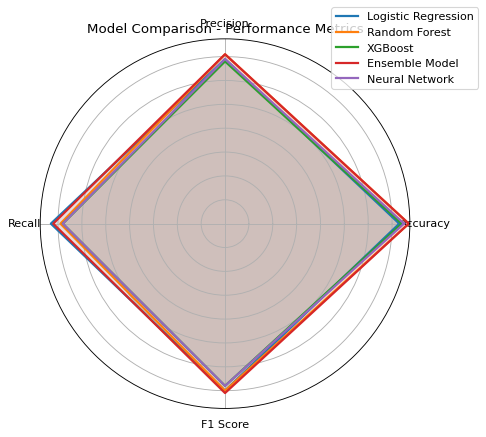

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the model comparison metrics for radar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
log_reg = [0.73, 0.69, 0.73, 0.70]  # Logistic Regression
rf = [0.77, 0.71, 0.69, 0.70]      # Random Forest
xgb = [0.74, 0.68, 0.68, 0.68]     # XGBoost
ensemble = [0.77, 0.71, 0.72, 0.71]  # Ensemble Model
nn = [0.75, 0.69, 0.68, 0.68]      # Neural Network

# Combine all models
data = np.array([log_reg, rf, xgb, ensemble, nn])

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Make the plot circular
data = np.concatenate((data, data[:,[0]]), axis=1)
angles += angles[:1]

# Create figure
fig, ax = plt.subplots(figsize=(6, 6), dpi=80, subplot_kw=dict(polar=True))

# Plot each model's data
for i, model in enumerate(['Logistic Regression', 'Random Forest', 'XGBoost', 'Ensemble Model', 'Neural Network']):
    ax.plot(angles, data[i], label=model, linewidth=2, linestyle='solid')

# Fill area
ax.fill(angles, data.T, alpha=0.1)

# Add labels and title
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('Model Comparison - Performance Metrics')

# Display the legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Show the radar chart
plt.show()

**Modeling Summary:**

Five different models were evaluated to identify the best classifier for the data. These models included Logistic Regression, Random Forest, XGBoost, an Ensemble model combining Logistic Regression, Random Forest, and XGBoost, and a Feedforward Neural Network.

The accuracy of all models ranged from 60% to 70%. Logistic Regression showed decent performance, while Random Forest and XGBoost performed well individually.

The ensemble model delivered the best performance with an accuracy of 77%, precision of 71%, recall of 72%, and an F1 score of 71%.

The Feedforward Neural Network model also performed well, yielding results similar to the ensemble model, making it a strong contender for the final recommendation.

Given its flexibility and the ability to tune parameters of the individual models, we recommend using the ensemble model for final deployment.


**Final Recommendation:** Ensemble Model with Logistic Regression, Random Forest and XGBoost can be used for detecting insurance fraud.

**Limitations:**

	1.	The overall accuracy, precision, recall, and F1 scores are in the 70% range, with even lower performance for the fraud class. This indicates that the model is not efficient in correctly identifying fraudulent claims, which is critical for fraud detection systems. The imbalance between fraudulent and non-fraudulent claims likely contributes to this limitation, as the models are more inclined to predict the majority class (non-fraud) due to the class distribution.
	2.	Feature Selection: While some features were selected, the model may still benefit from additional feature engineering, as important patterns could be hidden within less obvious features.

**Future Scope for Improvement:**

	1.	Advanced Feature Engineering: More advanced techniques such as feature scaling, polynomial feature generation, and interaction terms could be explored to capture complex relationships between the features.
	2.	Hyperparameter Optimization: More advanced hyperparameter tuning techniques like Randomized Search or Bayesian Optimization could be used to find the best settings for each model, particularly for more complex models like XGBoost and Neural Networks.
	3.	Ensemble Methods: The current ensemble model combines basic models, but more sophisticated ensemble techniques (e.g., stacking) could be explored to improve the final prediction accuracy.
	4.	Real-time Prediction: The project could evolve into a real-time fraud detection system that dynamically updates the models as new claims come in, making the system more responsive and effective at catching fraudulent claims in real-time.

In [ ]:
#import insurance_claims data as df
df = pd.read_csv('insurance_claims.csv')

# List of columns that were label-encoded
label_encoded_cols = ['policy_state', 'incident_state', 'insured_sex', 'insured_education_level',
                      'insured_occupation',
                      'incident_type', 'collision_type', 'incident_severity',
                      'authorities_contacted', 'property_damage',
                      'police_report_available', 'auto_model']

# Create a copy of x_test to decode and export
decoded_x_test = x_test.copy()

# For each categorical column, re-fit a LabelEncoder on insurance_df and decode x_test
for col in label_encoded_cols:
    le = LabelEncoder()
    le.fit(df[col])  # Fit encoder on full dataset
    decoded_x_test[col] = le.inverse_transform(x_test[col])

In [ ]:
tableau_df = decoded_x_test.copy()
tableau_df['fraud_reported'] = y_test.values
tableau_df['predicted_fraud'] = y_pred
tableau_df['fraud_probability'] = y_probs


tableau_df['actual_fraud'] = y_test.values
tableau_df.head()


months_as_customer policy_state  policy_annual_premium insured_sex  \
521                   5           IL                1137.02      FEMALE   
737                 160           IL                1422.78      FEMALE   
740                 385           IN                 976.37      FEMALE   
660                 446           IN                1373.21        MALE   
411                  84           OH                1117.17      FEMALE   

    insured_education_level insured_occupation             incident_type  \
521                     PhD    farming-fishing  Single Vehicle Collision   
737             High School    exec-managerial   Multi-vehicle Collision   
740                      MD       craft-repair   Multi-vehicle Collision   
660                 College       adm-clerical   Multi-vehicle Collision   
411             High School  machine-op-inspct                Parked Car   

      collision_type incident_severity authorities_contacted  ...  \
521   Rear Collision        Total Loss             Ambulance  ...   
737  Front Collision        Total Loss             Ambulance  ...   
740   Rear Collision      Minor Damage                Police  ...   
660  Front Collision        Total Loss                   NaN  ...   
411                ?    Trivial Damage                   NaN  ...   

    police_report_available total_claim_amount  injury_claim property_claim  \
521                       ?              88110         16020          16020   
737                     YES              52800          5280           5280   
740                       ?              67600         13520           6760   
660                      NO              62800          6280          12560   
411                     YES               6820           620           1240   

     vehicle_claim  auto_model  fraud_reported  predicted_fraud  \
521          56070          A5               0                0   
737          42240  Pathfinder               0                0   
740          47320      Legacy               0                0   
660          43960    Wrangler               0                0   
411           4960    3 Series               0                0   

    fraud_probability  actual_fraud  
521          0.079884             0  
737          0.110944             0  
740          0.220627             0  
660          0.127838             0  
411          0.055579             0  

[5 rows x 23 columns]

In [ ]:
tableau_df.to_csv('tableau_df.csv', index=False)